In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Lasso

/var/folders/83/l4pf1ccj1zjg__2f5qtgzqhm0000gn/T/ipykernel_65637/3122945918.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})


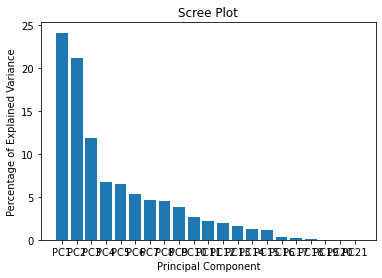

PC2     0.201563
PC6     0.192061
PC9     0.093385
PC8     0.053768
PC5     0.022722
PC3     0.011284
PC4     0.003929
PC7    -0.059350
PC10   -0.107302
PC1    -0.737142
Name: wl_home, dtype: float64


In [2]:
gameDataframe = pd.read_csv("game.csv")
# print(gameDataframe)
gameDataframe['game_date'] = pd.to_datetime(gameDataframe['game_date'])

# Filter the data to only include rows from 2000 onwards
filtered_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2000]
# print(filtered_df)

filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})
filtered_df = filtered_df.reset_index(drop=True)

#####

non_numeric_columns = filtered_df.select_dtypes(exclude =[np.number]).columns
filtered_df = filtered_df.select_dtypes(include = [np.number])

####

correlations = filtered_df.corr()['wl_home'].abs().sort_values(ascending=False)
remainingFeatures = correlations[correlations > .15].index #indexes of all features with a correlations above 15 percent towards the win or loss of a home team
# print(remainingFeatures)

scaler = StandardScaler()
reducedData = filtered_df[remainingFeatures].drop(columns=['wl_home'])
scaledData = scaler.fit_transform(reducedData)
pca = PCA()
# pca.fit(scaledData)
pcaData = pca.fit_transform(scaledData)

percentVar = np.round(pca.explained_variance_ratio_*100,decimals= 1)
labels = ['PC' + str(x) for x in range(1,len(percentVar) + 1)]
plt.bar(x = range(1,len(percentVar)+1),height=percentVar,tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()


pca_df = pd.DataFrame(pcaData[:,:10], columns=[f'PC{i+1}' for i in range(10)]) #top 10 principal components account for ~90% variance 
pca_df['wl_home'] = filtered_df['wl_home']
correlations_with_win = pca_df.corr()['wl_home'].drop('wl_home').sort_values(ascending=False)
# print(filtered_df['wl_home'])
# print(pca_df)
print(correlations_with_win)

Observing the Scree plot give us insight towards the Principal Components that contribute the highest percentage of variance in general. It's important to note that this is general variance, not variance directly pertaining towards the win or loss of the home team. 

Conversely, the printed correlations are tied directly to the win or loss of the home team for each Principal Component. As we can see, the most explanatory principal component is PC1, which is negatively correlated with the win or loss of the home team. Meaning, if there is a high value for PC1 in a given game, that game lends itself to being more likely to having been a loss for the home team. While other factors such as PC2 and PC6 are among the higher correlated PC's with W/L, their correlation contstant is not nearly as dominant as PC1's.

It's important to note, this is data collected after the fact. Since our model is looking to predict the outcome of games, these statistics can't necessarily help us as we have no indication as to how these features will play out in a given game. However, there is some merit into observing the cumulative of these values leading up to each game. If a team is consistently putting up high contributions towards the PC1 feature, for example, we could therefore assume it is less likely they will win their following game.

/var/folders/83/l4pf1ccj1zjg__2f5qtgzqhm0000gn/T/ipykernel_65637/611175977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})


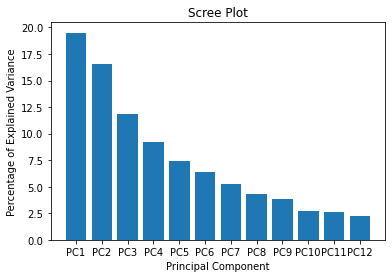

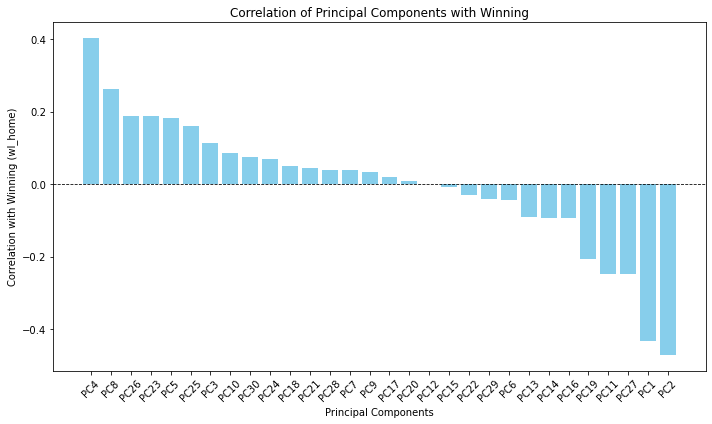

In [3]:
filtered_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2023]
# print(filtered_df)
filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})
filtered_df = filtered_df.reset_index(drop=True)
filtered_df = filtered_df.sort_values(by='game_date')
# hometeam_df = filtered_df.groupby('team_name_home')


mean_last_10_games = (
    filtered_df.groupby('team_name_home')
    .apply(lambda x: x.tail(10).select_dtypes(include='number').mean())  # Get the mean of the last 10 games per team
    .drop(columns=['season_id','team_id_home','game_id'])
    .reset_index(drop = True)
    # .drop(columns=['wl_home'])  # Optional: Drop 'wl_home' if it's not needed in the result
)

# print(mean_last_10_games)
correlations = mean_last_10_games.corr()['wl_home'].sort_values(ascending=False)
# print(correlations)
# remainingFeatures = correlations[correlations > .15].index #indexes of all features with a correlations above 15 percent towards the win or loss of a home team
# print(remainingFeatures)

scaler = StandardScaler()
reducedData = mean_last_10_games.drop(columns=['wl_home'])
reducedData = reducedData.dropna()
scaledData = scaler.fit_transform(reducedData)
pca = PCA()
pcaData = pca.fit_transform(scaledData)

percentVar = np.round(pca.explained_variance_ratio_[:12]*100,decimals= 1)
labels = ['PC' + str(x) for x in range(1,13)]
plt.bar(x = range(1,13),height=percentVar,tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')

pca_df = pd.DataFrame(pcaData, columns=[f'PC{i+1}' for i in range(pcaData.shape[1])]) #top 10 principal components account for ~90% variance 
pca_df['wl_home'] = mean_last_10_games['wl_home']
# print(pca_df)
pcacorrelations_with_win = pca_df.corr()['wl_home'].drop('wl_home').sort_values(ascending=False)
# print(filtered_df['wl_home'])
# print(pca_df)
# print(pcacorrelations_with_win)

plt.figure(figsize=(10, 6))
plt.bar(pcacorrelations_with_win.index, pcacorrelations_with_win.values, color='skyblue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Correlation of Principal Components with Winning')
plt.xlabel('Principal Components')
plt.ylabel('Correlation with Winning (wl_home)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

pca_df['win_category'] = np.where(pca_df['wl_home'] >= 0.5, 'Above 50%', 'Below 50%')

# fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC4', color='wl_home',
#                     labels={'wl_home': 'Win Percentage'},
#                     title='3D Scatter Plot of PCA Components vs Win Percentage',
#                     color_continuous_scale=px.colors.sequential.Viridis)

fig = px.scatter(pca_df,x = 'PC1', y= 'PC2', color = 'wl_home')
fig.show()

# 3D Scatter Plot using Plotly with 2 color categories
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC4', color='win_category',
                    color_discrete_map={'Above 50%': 'blue', 'Below 50%': 'red'},
                    title='3D Scatter Plot of PCA Components vs Win Percentage')

# Update layout for better readability
fig.update_traces(marker=dict(size=5))  # Adjust marker size if needed
fig.update_layout(scene=dict(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    zaxis_title='Principal Component 4',
))

fig.show()


This portion of the data reduction is much more relevant towards the scope of our project. By focusing on the mean of the features of each team from their last 10 games, we can get a good understanding of how the team is performing in general at the time of their upcoming games, as well as the most important features that are contributing towards their wins or losses. 

By identifying the principal components that are most directly correlated (positive or negative), we a good idea of predicting the outcomes of future games by using these principal components and seeing how they reflect a team leading up to their future games.

Looking at the bar graph from the second graphic, we can see that there are several PC's that are heavily correlated with winning. PC1 and PC2 are negatively correlated with winning, and PC4 is positively correlated with winning. While not perfect, we can get a general understanding of this by plotting it in a 3-Dimensional space as graphic #3 has done. As you can see, when we move towards a higher value of PC1 and PC2, the percentage of winning goes down, and conversely when we move towards a lower value of PC1 and PC2 winning goes up. The opposite can be true of PC4. While this portion of our project is not used to draw definitive conclusions or predictions, this can establish a solid foundation for our machine learning models to use when predicting the outcome of games.

In [4]:
filtered_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2000].copy()
filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.dropna(inplace=True)

non_numeric_columns = filtered_df.select_dtypes(exclude=[np.number]).columns
filtered_df = filtered_df.select_dtypes(include=[np.number])

correlations = filtered_df.corr()['wl_home'].abs().sort_values(ascending=False)

remainingFeatures = correlations[correlations > .15].index 

scaler = StandardScaler()
reducedData = filtered_df[remainingFeatures]
x_set = reducedData.drop(columns='wl_home')
y_set = reducedData['wl_home']
x_set_scaled = scaler.fit_transform(x_set)

pca_3 = PCA(n_components=3)
new_dataset = pca_3.fit_transform(x_set_scaled) # scaledData is just X

#########

clustering = DBSCAN()
clustering.fit(new_dataset)
print(f'Number of clusters: {len(np.unique(clustering.labels_))}')
print(f'Number of "outliers": {len(np.where(clustering.labels_ == -1)[0])}')
print(f'N: {len(x_set)}')

# Do we want to delete these "outliers" from the dataset?

Number of clusters: 35
Number of "outliers": 1226
N: 30421


In [5]:
cleaned_game_stats_home = filtered_df.iloc[:, 7:28].copy() # only the home numerical data
# print(cleaned_game_stats_home)
cleaned_game_stats_home.dropna(inplace=True)
x_set = cleaned_game_stats_home.iloc[:, 1:]
# print(x_set)
x_set_std = (x_set-x_set.mean())/x_set.std()
y_set = cleaned_game_stats_home.iloc[:, 0]
# print(y_set)

In [6]:
lasso_fit = Lasso(alpha=0.02, max_iter=10000)
lasso_fit.fit(x_set_std, y_set)
feats = np.where(lasso_fit.coef_ != 0)[0]
feats

array([ 9, 14, 15])

In [7]:
selected_dataset = x_set.iloc[:, feats]

clustering = DBSCAN(eps=0.5, min_samples=3)
clustering.fit(selected_dataset)
print(f'Number of clusters: {len(np.unique(clustering.labels_))}')
print(f'Number of "outliers": {len(np.where(clustering.labels_ == -1)[0])}')
print(f'N: {len(x_set)}')

Number of clusters: 2564
Number of "outliers": 21103
N: 30421
